### Import Libraries

In [296]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import itertools as itertls
import warnings

from tqdm import notebook
from tqdm import tqdm 
from typing import Union

# from scipy.stats import pearsonr, spearmanr, chi2, chi2_contingency
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess

from sklearn.metrics import mean_squared_error, mean_absolute_error, \
                            mean_absolute_percentage_error

In [230]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  "font.size": 16,
  "grid.alpha": 0.25})

### Function declarations

In [231]:
def plot_time_series(x, y, xlabel="Time", ylabel="Value", figsize=(10, 4), 
                     use_date_locator=True, title=None, use_scatter=True):
    fig, ax = plt.subplots(figsize=figsize)

    ax.plot(x, y, linestyle="-", marker=".")

    if use_date_locator:
        formatter = mdates.DateFormatter("%d/%m/%Y")
        # locator = mdates.WeekLocator()
        # locator = mdates.YearLocator(base=2)
        locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
        ax.xaxis.set_major_formatter(formatter)
        ax.xaxis.set_major_locator(locator)

    ax.grid("on")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if title is not None:
        ax.set_title(title)

    if use_date_locator:
        for j, label in enumerate(ax.get_xticklabels()):
            label.set_rotation(40)
            label.set_horizontalalignment('right')

    plt.show()


### Pre-processing

In [232]:
file_path = "./data/CDB THN 2021-2024.csv"
df_cdb = pd.read_csv(file_path)
df_cdb["Tgl. Mohon"] = pd.to_datetime(df_cdb["Tgl. Mohon"], format="%d/%m/%Y")
df_cdb["Tgl. Lahir"] = pd.to_datetime(df_cdb["Tgl. Lahir"], format="%d/%m/%Y")
df_cdb

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA
...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0


In [233]:
df_cdb_with_initial = df_cdb.copy()
df_cdb_with_initial["initial Varian Plus"] = df_cdb_with_initial["Varian Plus"].apply(lambda x: x[0])
df_cdb_with_initial

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0,L
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0,L
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA,L
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0,L
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA,L
...,...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0,M
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0,M
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3,L
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0,M


In [234]:
df_cdb_with_tipe = df_cdb_with_initial.copy()

def tipe_customer(row):
    if row[["Gender", "Tgl. Lahir", "Pekerjaan", "Pengeluaran", "Pendidikan"]].isnull().any():
        return "INSTANSI LUAR"
    else:
        return "INDIVIDU"

df_cdb_with_tipe["Tipe Pembeli"] = df_cdb_with_tipe.apply(tipe_customer, axis=1)
df_cdb_with_tipe["Umur"] = (pd.to_datetime("today") - df_cdb_with_tipe["Tgl. Lahir"]).dt.days // 365

df_cdb_with_tipe

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus,Tipe Pembeli,Umur
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0,L,INDIVIDU,28
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0,L,INDIVIDU,21
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA,L,INDIVIDU,28
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0,L,INDIVIDU,42
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA,L,INDIVIDU,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0,M,INDIVIDU,20
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0,M,INDIVIDU,47
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3,L,INDIVIDU,64
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0,M,INDIVIDU,44


### Plot kumulatif

Take initial varian plus "H"

In [235]:
df_H = df_cdb_with_tipe[df_cdb_with_tipe["initial Varian Plus"] == "H"].copy()
df_H

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus,Tipe Pembeli,Umur
12,2021-01-05,JULI HARJANTO,JL BLORA,KLANDASAN ILIR,BALIKPAPAN KOTA,LAKI-LAKI,1977-07-18,Pegawai Swasta-Jasa,"< Rp. 900.000,-",SLTA/SMU,HZ3,H,INDIVIDU,47
13,2021-01-06,"DHINA R. AGUSTIANA DA, SE",JL MASJID AR RAUDAH I,GUNUNG BAHAGIA,BALIKPAPAN SELATAN,PEREMPUAN,1974-08-13,IBU RUMAH TANGGA,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SARJANA,HWC,H,INDIVIDU,50
24,2021-01-07,AHMAD HABIBI HARAHAP,JL DAKSA TIMUR I,SEPINGGAN,BALIKPAPAN SELATAN,LAKI-LAKI,1995-04-30,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,HDN,H,INDIVIDU,29
31,2021-01-07,GALIH PUTRO WICAKSONO,JL JEND SUDIRMAN ASPOL STAL KUDA,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1993-05-26,TNI/POLRI,"< Rp. 900.000,-",AKADEMI/DIPLOMA,HZ3,H,INDIVIDU,31
37,2021-01-09,VELIANA FEBRIANTI,JL GUNUNG GEMBIRA,BARU ILIR,BALIKPAPAN BARAT,PEREMPUAN,1997-02-25,Pegawai Swasta-Perdagangan,"< Rp. 900.000,-",SLTA/SMU,HS2,H,INDIVIDU,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5956,2024-04-06,ERNIE DIANA NUR,JL. SIDOMULYO,MARGO MULYO,BALIKPAPAN BARAT,PEREMPUAN,1977-08-14,IBU RUMAH TANGGA,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,HDP,H,INDIVIDU,47
6330,2024-06-06,ERNI,JL. WOLTET MONGINSIDI GG. MACAN,BARU ULU,BALIKPAPAN BARAT,PEREMPUAN,1977-07-07,Wiraswasta-Jasa,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,HD7,H,INDIVIDU,47
6351,2024-06-10,ZULFIKAR,JL TELINDUNG,BATU AMPAR,BALIKPAPAN UTARA,LAKI-LAKI,1988-02-07,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,HJ9,H,INDIVIDU,37
6501,2024-07-08,JOSUA,JL JENDRAL SUDIRMAN,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,2000-07-22,Pegawai Swasta-Jasa,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,HDN,H,INDIVIDU,24


Plot data initial varian plus "H"

In [236]:
df_H_count = df_H[["Tgl. Mohon"]].copy()
df_H_count["count"] = 1.
df_H_count = df_H_count.groupby("Tgl. Mohon").agg("count").reset_index()
df_H_count["cumulative_sum"] = df_H_count["count"].cumsum()
df_H_count

,Tgl. Mohon,count,cumulative_sum
0,2021-01-05,1,1
1,2021-01-06,1,2
2,2021-01-07,2,4
3,2021-01-09,1,5
4,2021-01-11,1,6
...,...,...,...
295,2024-04-06,1,443
296,2024-06-06,1,444
297,2024-06-10,1,445
298,2024-07-08,1,446


Groub by weekly

In [237]:
df_H_weekly = df_H_count[["Tgl. Mohon"]].copy()
df_H_count["Tgl. Mohon"] = pd.to_datetime(df_H_count["Tgl. Mohon"])

df_H_weekly = (df_H.resample("W-MON", on="Tgl. Mohon").size()
                .reset_index(name="count"))

df_H_weekly["cumulative_sum"] = df_H_weekly["count"].cumsum()
df_H_weekly


,Tgl. Mohon,count,cumulative_sum
0,2021-01-11,6,6
1,2021-01-18,7,13
2,2021-01-25,8,21
3,2021-02-01,9,30
4,2021-02-08,4,34
...,...,...,...
182,2024-07-08,1,446
183,2024-07-15,0,446
184,2024-07-22,0,446
185,2024-07-29,0,446


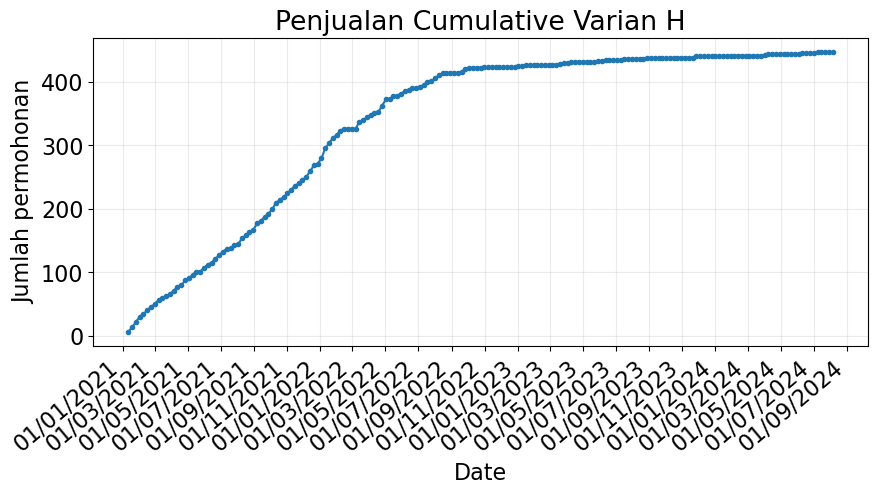

In [238]:
plot_time_series(df_H_weekly["Tgl. Mohon"], df_H_weekly["cumulative_sum"], 
                title="Penjualan Cumulative Varian H",
                xlabel="Date", ylabel="Jumlah permohonan")

#### weekly

In [239]:
ADF_result = adfuller(df_H_weekly["cumulative_sum"])
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: -2.7844259742611865
p-value: 0.06053307410871535


first diff (_d_=1)

In [240]:
H_diff = np.diff(df_H_weekly["cumulative_sum"], n=1)
ADF_result = adfuller(H_diff)
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: -2.218979090316571
p-value: 0.19942939068380056


sec diff (_d_=2)

In [241]:
H_diff2 = np.diff(H_diff, n=1)
ADF_result2 = adfuller(H_diff2)
print(f"ADF statistic : {ADF_result2[0]}")
print(f"p-value : {ADF_result2[1]}")


ADF statistic : -6.577661944444589
p-value : 7.653176391424563e-09


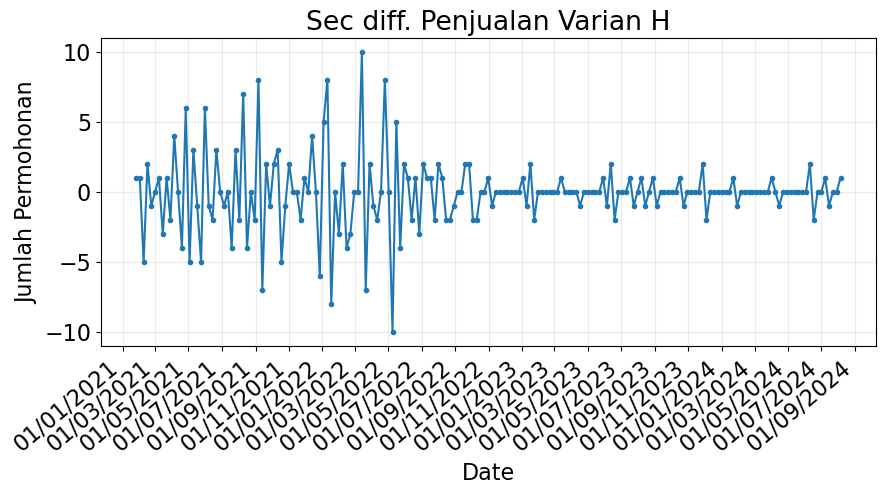

In [242]:
plot_time_series(df_H_weekly["Tgl. Mohon"].iloc[2:], H_diff2, 
                 title="Sec diff. Penjualan Varian H",
                 xlabel="Date", ylabel="Jumlah Permohonan")

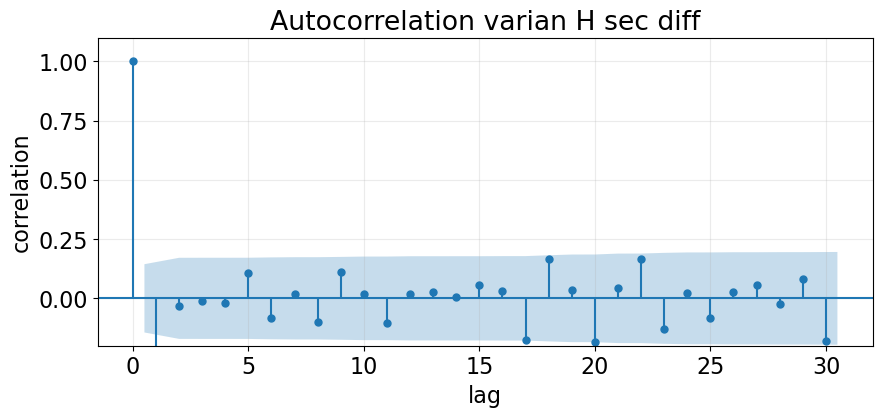

In [243]:
fig, ax = plt.subplots(figsize=(10, 4))

fig = plot_acf(H_diff2, lags=30, ax=ax)

ax.set_ylim([-.2, 1.1])
ax.set_ylabel("correlation")
ax.set_xlabel("lag")
ax.set_title("Autocorrelation varian H sec diff")
ax.grid("on")

plt.show(fig)

### harian

In [244]:
ADF_result = adfuller(df_H_count["cumulative_sum"])
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: -0.3392149967781675
p-value: 0.9197637589674756


fisrt diff (_d_=1)

In [245]:
H_diff = np.diff(df_H_count["cumulative_sum"], n=1)
ADF_result = adfuller(H_diff)
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: -15.090296800551595
p-value: 8.211663269657256e-28


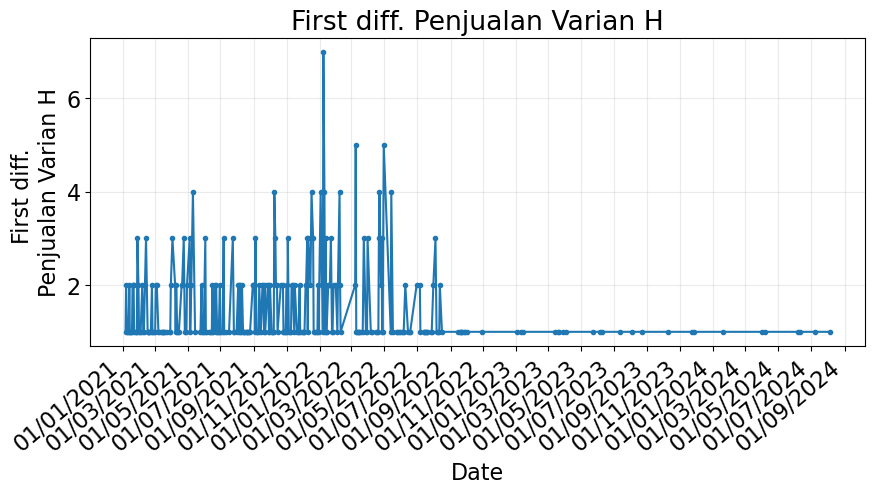

In [246]:
plot_time_series(df_H_count["Tgl. Mohon"].iloc[1:], H_diff, 
                 title="First diff. Penjualan Varian H",
                 xlabel="Date", ylabel="First diff. \nPenjualan Varian H")

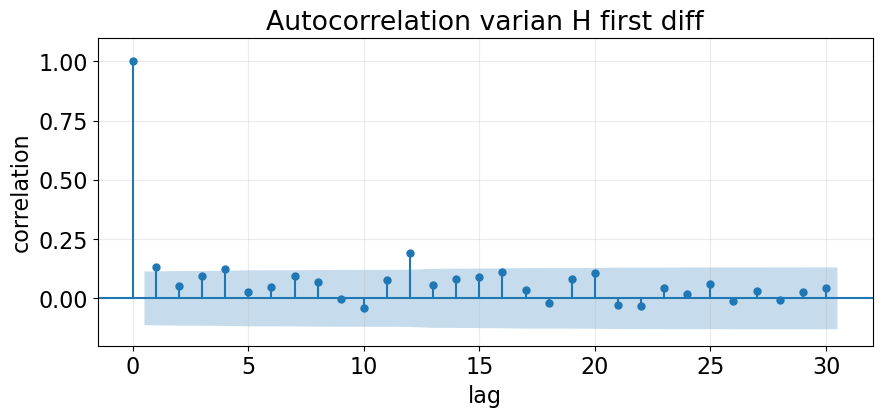

In [247]:
fig, ax = plt.subplots(figsize=(10, 4))

fig = plot_acf(H_diff, lags=30, ax=ax)

ax.set_ylim([-.2, 1.1])
ax.set_ylabel("correlation")
ax.set_xlabel("lag")
ax.set_title("Autocorrelation varian H first diff")
ax.grid("on")

plt.show(fig)

MA(1)

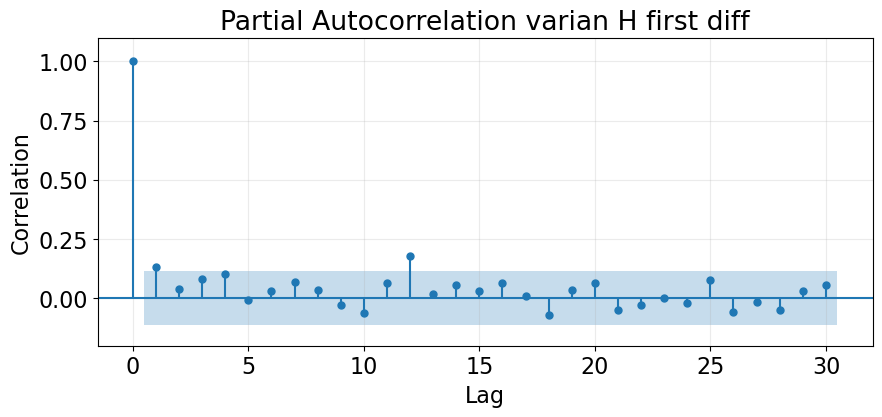

In [248]:
fig, ax = plt.subplots(figsize=(10, 4))

plot_pacf(H_diff, lags=30, ax=ax)

ax.set_ylim([-0.2, 1.1])
ax.set_ylabel("Correlation")
ax.set_xlabel("Lag")
ax.set_title("Partial Autocorrelation varian H first diff")
ax.grid("on")

plt.show()

AR(1)

### Data Splitting

In [249]:
df_H_diff = pd.DataFrame({
    "Tgl. Mohon": df_H_count["Tgl. Mohon"].iloc[1:],
    "H_diff": H_diff})

split_idx = int(0.8 * len(df_H_diff))
df_train = df_H_diff.iloc[:split_idx].copy()
df_test = df_H_diff.iloc[split_idx:].copy()

print(f"(len(df_train), len(df_test)): {len(df_train), len(df_test)}")

(len(df_train), len(df_test)): (239, 60)


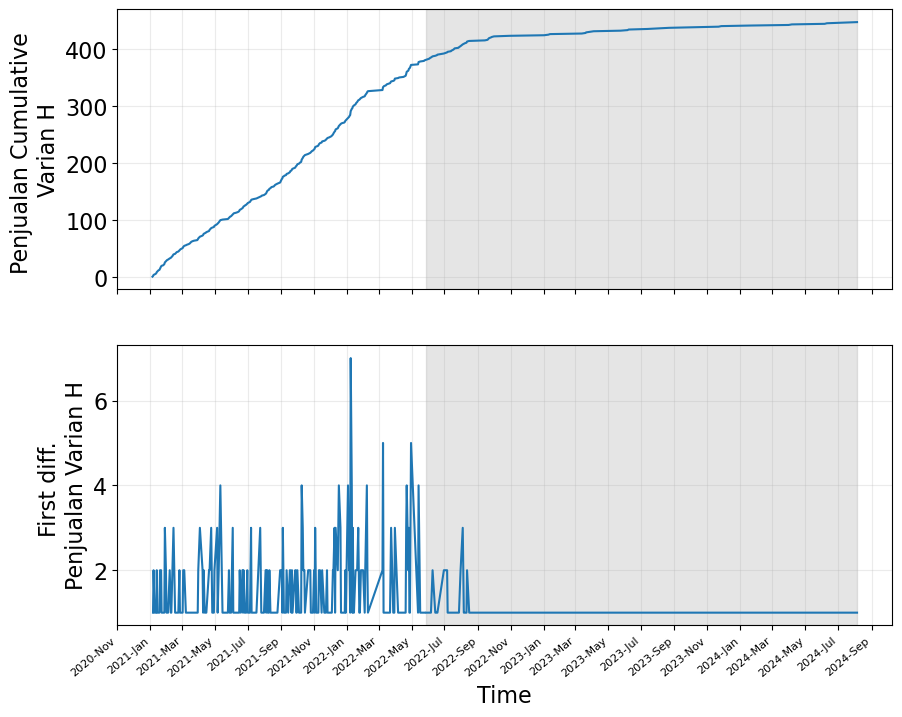

In [250]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

# -- first row
axes[0].plot(df_H_count["Tgl. Mohon"], df_H_count["cumulative_sum"])
axes[0].grid("on")
axes[0].set_ylabel("Penjualan Cumulative \nVarian H")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
axes[0].xaxis.set_major_formatter(formatter)
axes[0].xaxis.set_major_locator(locator)

# -- second row
axes[1].plot(df_train["Tgl. Mohon"], df_train["H_diff"])
axes[1].plot(df_test["Tgl. Mohon"], df_test["H_diff"], color="tab:blue")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("First diff. \nPenjualan Varian H")
axes[1].grid("on")

# add forecast area
for j in range(2):
  axes[j].axvspan(df_test["Tgl. Mohon"].iloc[0], df_test["Tgl. Mohon"].iloc[-1], 
                  color="#808080", alpha=0.2)

for j, label in enumerate(axes[1].get_xticklabels()):
  label.set_rotation(40)
  label.set_size(8)
  label.set_horizontalalignment('right')

plt.show(fig)

### MA(1) AR(1)

In [251]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, 
                      method: str) -> list:
  """
  The following models using all the dataframe (train + test),
  because we roll out forecast with a correct data with the length
  of forecast is equal to `horizon`
  """
  total_len = train_len + horizon

  if method == "mean":
    pred_mean = []

    for i in range(train_len, total_len, window):
      mean = np.mean(df[:i]["H_diff"])
      pred_mean.extend(mean for _ in range(window))
    # print(len(pred_mean), horizon)
    if len(pred_mean) > horizon:  # cut over counting in (mean for _ in range(window))
      pred_mean = pred_mean[:horizon]

    return pred_mean

  elif method == "last":
    pred_last_value = []

    for i in range(train_len, total_len, window):
      last_value = df[:i]["H_diff"].iloc[-1]
      pred_last_value.extend(last_value for _ in range(window))

    if len(pred_last_value) > horizon:  # cut over counting in (last_value for _ in range(window))
      pred_last_value = pred_last_value[:horizon]

    return pred_last_value

  elif method == "MA":
    pred_MA = []

    for i in range(train_len, total_len, window):
      # model = ARMA(df[:i]["H_diff"], order=(0, 1))
      model = SARIMAX(df[:i]["H_diff"], order=(0, 0, 1))
      res = model.fit(disp=False)
      predictions = res.get_prediction(0, i + window - 1)
      oos_pred = predictions.predicted_mean.iloc[-window:]   # oos: output of sarimax
      pred_MA.extend(oos_pred)

    if len(pred_MA) > horizon:  # cut over counting in (.iloc[-window:])
      pred_MA = pred_MA[:horizon]

    return pred_MA

  elif method == "AR":
    pred_AR = []

    for i in range(train_len, total_len, window):
      model = SARIMAX(df[:i]["H_diff"], order=(1, 0, 0))
      res = model.fit(disp=False)
      predictions = res.get_prediction(0, i + window - 1)
      oos_pred = predictions.predicted_mean.iloc[-window:]   # oos: output of sarimax
      pred_AR.extend(oos_pred)

    return pred_AR

In [252]:
pred_df = df_test.copy()

TRAIN_LEN = len(df_train)
HORIZON = len(df_test)
WINDOW = 6

pred_mean = rolling_forecast(df_H_diff, TRAIN_LEN, HORIZON, WINDOW, "mean")
pred_last_value = rolling_forecast(df_H_diff, TRAIN_LEN, HORIZON, WINDOW, "last")
pred_MA = rolling_forecast(df_H_diff, TRAIN_LEN, HORIZON, WINDOW, "MA")
pred_AR = rolling_forecast(df_H_diff, TRAIN_LEN, HORIZON, WINDOW, "AR")

pred_df["pred_mean"] = pred_mean
pred_df["pred_last_value"] = pred_last_value
pred_df["pred_MA"] = pred_MA
pred_df["pred_AR"] = pred_AR

pred_df

,Tgl. Mohon,H_diff,pred_mean,pred_last_value,pred_MA,pred_AR
240,2022-05-28,1,1.585774,1,0.029000,0.767772
241,2022-05-31,1,1.585774,1,0.000000,0.589473
242,2022-06-03,1,1.585774,1,0.000000,0.452581
243,2022-06-04,1,1.585774,1,0.000000,0.347479
244,2022-06-06,1,1.585774,1,0.000000,0.266785
245,2022-06-09,2,1.585774,1,0.000000,0.204830
246,2022-06-14,1,1.575510,2,0.868762,1.541517
247,2022-06-17,1,1.575510,2,0.000000,1.188137
248,2022-06-18,1,1.575510,2,0.000000,0.915766
249,2022-06-30,2,1.575510,2,0.000000,0.705835


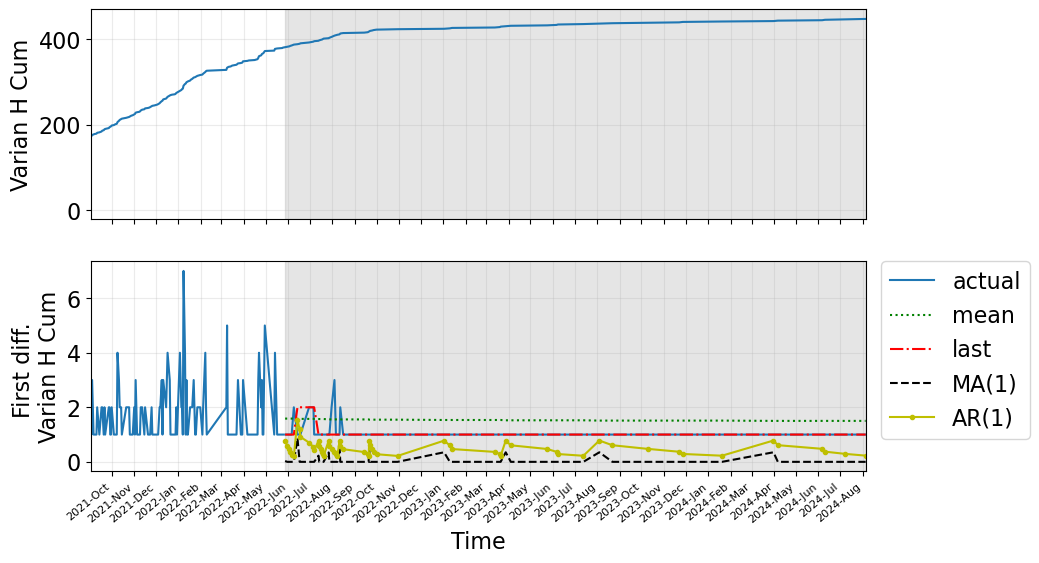

In [253]:
start_idx = 120  # for better visualization
xlim = [df_train["Tgl. Mohon"].iloc[start_idx], df_test["Tgl. Mohon"].iloc[-1]]

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 6))


# -- second row
axes[1].plot(df_train["Tgl. Mohon"], df_train["H_diff"])
axes[1].plot(df_test["Tgl. Mohon"], df_test["H_diff"], color="tab:blue", label="actual")

formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
axes[0].xaxis.set_major_formatter(formatter)
axes[0].xaxis.set_major_locator(locator)

axes[1].set_xlabel("Time")
axes[1].set_ylabel("First diff. \nVarian H Cum")
axes[1].grid("on")

# -- prediction
axes[1].plot(pred_df["Tgl. Mohon"], pred_df["pred_mean"], "g:", label="mean")
axes[1].plot(pred_df["Tgl. Mohon"], pred_df["pred_last_value"], "r-.", label="last")
axes[1].plot(pred_df["Tgl. Mohon"], pred_df["pred_MA"], "k--", label="MA(1)")
axes[1].plot(pred_df["Tgl. Mohon"], pred_df["pred_AR"], "y.-", label="AR(1)")


# add forecast area
for j in range(2):
  axes[j].axvspan(df_test['Tgl. Mohon'].iloc[0], df_test['Tgl. Mohon'].iloc[-1], 
                  color="#808080", alpha=0.2)

for j, label in enumerate(axes[1].get_xticklabels()):
  label.set_rotation(40)
  label.set_size (8)
  label.set_horizontalalignment('right')

# -- add legend in the second row
axes[1].legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

# -- first row
axes[0].plot(df_H_count['Tgl. Mohon'], df_H_count["cumulative_sum"])

axes[0].grid("on")
axes[0].set_ylabel("Varian H Cum")
axes[0].set_xlim(xlim)


plt.show(fig)

In [254]:
mse_mean = mean_squared_error(pred_df["H_diff"], pred_df["pred_mean"])
mse_last = mean_squared_error(pred_df["H_diff"], pred_df["pred_last_value"])
mse_MA = mean_squared_error(pred_df["H_diff"], pred_df["pred_MA"])
mse_AR = mean_squared_error(pred_df["H_diff"], pred_df["pred_AR"])

print(f"MSE mean: {mse_mean}")
print(f"MSE last: {mse_last}")
print(f"MSE MA: {mse_MA}")
print(f"MSE AR: {mse_AR}")

MSE mean: 0.31683920657726933
MSE last: 0.18333333333333332
MSE MA: 1.2870406381781772
MSE AR: 0.5966637523105686


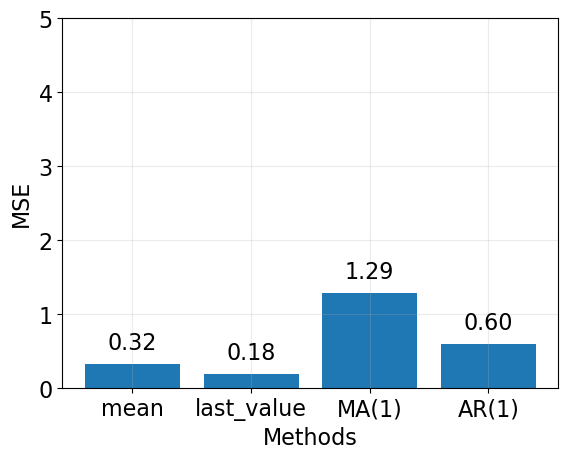

In [255]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "MA(1)", "AR(1)"]
y_array = [mse_mean, mse_last, mse_MA, mse_AR]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MSE")
ax.set_ylim([0, 5])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)

In [256]:
idx_y0 = len(df_train) + 1 
y0 = df_H_count.iloc[idx_y0]["cumulative_sum"]
# print(y0)
df_test_H = df_H_count[idx_y0:].copy()
df_test_H["pred_mean"] = y0 + pred_df["pred_mean"].cumsum()
df_test_H["pred_last_value"] = y0 + pred_df["pred_last_value"].cumsum()
df_test_H["pred_MA"] = y0 + pred_df["pred_MA"].cumsum()
df_test_H["pred_AR"] = y0 + pred_df["pred_AR"].cumsum()
df_test_H.head()

,Tgl. Mohon,count,cumulative_sum,pred_mean,pred_last_value,pred_MA,pred_AR
240,2022-05-28,1,381,382.585774,382,381.029,381.767772
241,2022-05-31,1,382,384.171548,383,381.029,382.357245
242,2022-06-03,1,383,385.757322,384,381.029,382.809826
243,2022-06-04,1,384,387.343096,385,381.029,383.157305
244,2022-06-06,1,385,388.928870,386,381.029,383.424090


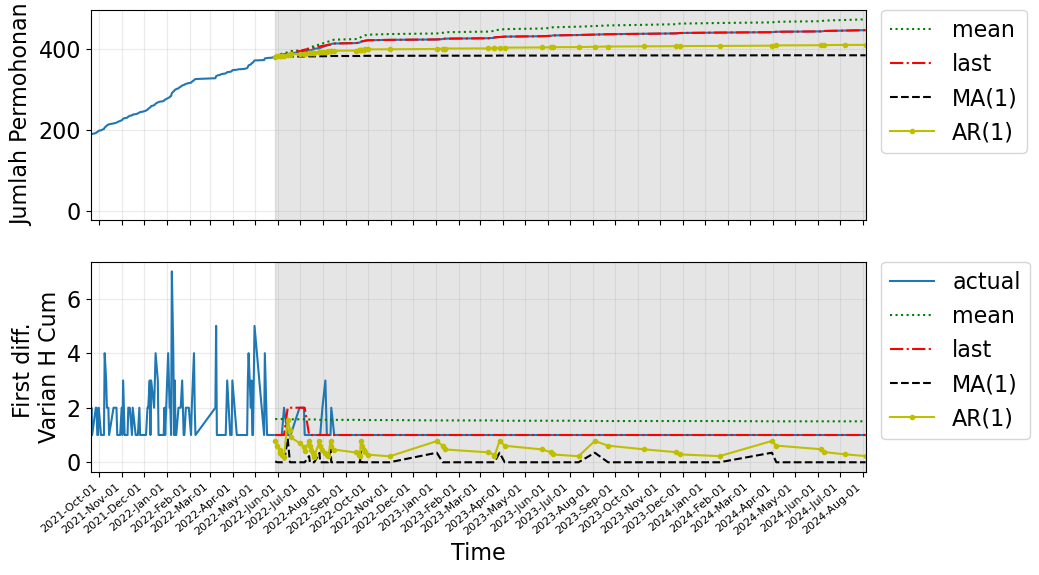

In [257]:
start_idx = 130  # for better visualization
xlim = [df_train["Tgl. Mohon"].iloc[start_idx], df_test["Tgl. Mohon"].iloc[-1]]

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 6))

# -- second row
axes[1].plot(df_train["Tgl. Mohon"], df_train["H_diff"])
axes[1].plot(df_test["Tgl. Mohon"], df_test["H_diff"], color="tab:blue", label="actual")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b-%d")
locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
# locator = mdates.DayLocator()
axes[0].xaxis.set_major_formatter(formatter)
axes[0].xaxis.set_major_locator(locator)

axes[1].set_xlabel("Time")
axes[1].set_ylabel("First diff. \nVarian H Cum")
axes[1].grid("on")

# -- prediction
axes[1].plot(pred_df["Tgl. Mohon"], pred_df["pred_mean"], "g:", label="mean")
axes[1].plot(pred_df["Tgl. Mohon"], pred_df["pred_last_value"], "r-.", label="last")
axes[1].plot(pred_df["Tgl. Mohon"], pred_df["pred_MA"], "k--", label="MA(1)")
axes[1].plot(pred_df["Tgl. Mohon"], pred_df["pred_AR"], "y.-", label="AR(1)")


# add forecast area
for j in range(2):
  axes[j].axvspan(df_test['Tgl. Mohon'].iloc[0], df_test['Tgl. Mohon'].iloc[-1], 
                  color="#808080", alpha=0.2)

for j, label in enumerate(axes[1].get_xticklabels()):
  label.set_rotation(40)
  label.set_size(8)
  label.set_horizontalalignment('right')

# -- add legend in the second row
axes[1].legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

# -- first row
axes[0].plot(df_H_count['Tgl. Mohon'], df_H_count["cumulative_sum"])

# -- prediction for the original data
axes[0].plot(df_test_H['Tgl. Mohon'], df_test_H["pred_mean"], "g:", label="mean")
axes[0].plot(df_test_H['Tgl. Mohon'], df_test_H["pred_last_value"], "r-.", label="last")
axes[0].plot(df_test_H['Tgl. Mohon'], df_test_H["pred_MA"], "k--", label="MA(1)")
axes[0].plot(df_test_H['Tgl. Mohon'], df_test_H["pred_AR"], "y.-", label="AR(1)")

axes[0].grid("on")
axes[0].set_ylabel("Jumlah Permohonan")
axes[0].set_xlim(xlim)
axes[0].set_ylim()
axes[0].legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)


plt.show(fig)

### Evaluasi MA(1) AR(1)

MAE

In [258]:
mae_mean_undiff = mean_absolute_error(df_test_H["cumulative_sum"], df_test_H["pred_mean"])
mae_last_undiff = mean_absolute_error(df_test_H["cumulative_sum"], df_test_H["pred_last_value"])
mae_MA_undiff   = mean_absolute_error(df_test_H["cumulative_sum"], df_test_H["pred_MA"])
mae_AR_undiff   = mean_absolute_error(df_test_H["cumulative_sum"], df_test_H["pred_AR"])

print(f"MAE mean: {mae_mean_undiff}")
print(f"MAE last: {mae_last_undiff}")
print(f"MAE MA: {mae_MA_undiff}")
print(f"MAE AR: {mae_AR_undiff}")

MAE mean: 12.956962762574067
MAE last: 1.0
MAE MA: 32.52503292822127
MAE AR: 18.45456902086875


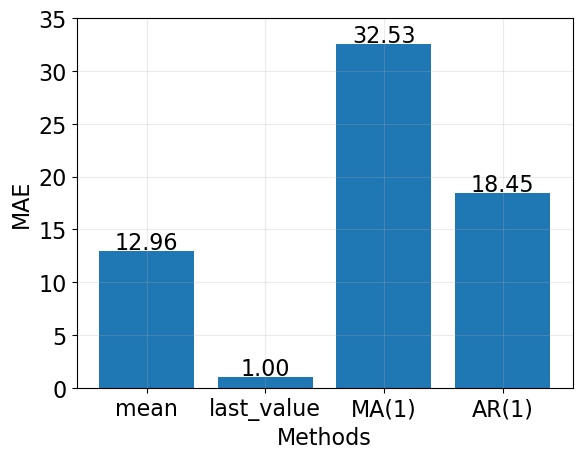

In [259]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "MA(1)", "AR(1)"]
y_array = [mae_mean_undiff, mae_last_undiff, mae_MA_undiff, mae_AR_undiff]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAE")
ax.set_ylim([0, 35])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)

MSE

In [260]:
mse_mean_undiff = mean_squared_error(df_test_H["cumulative_sum"], df_test_H["pred_mean"])
mse_last_undiff = mean_squared_error(df_test_H["cumulative_sum"], df_test_H["pred_last_value"])
mse_MA_undiff   = mean_squared_error(df_test_H["cumulative_sum"], df_test_H["pred_MA"])
mse_AR_undiff   = mean_squared_error(df_test_H["cumulative_sum"], df_test_H["pred_AR"])

print(f"MSE mean: {mse_mean_undiff}")
print(f"MSE last: {mse_last_undiff}")
print(f"MSE MA: {mse_MA_undiff}")
print(f"MSE AR: {mse_AR_undiff}")

MSE mean: 221.9173775485669
MSE last: 3.2333333333333334
MSE MA: 1395.8762256312698
MSE AR: 466.0386356559553


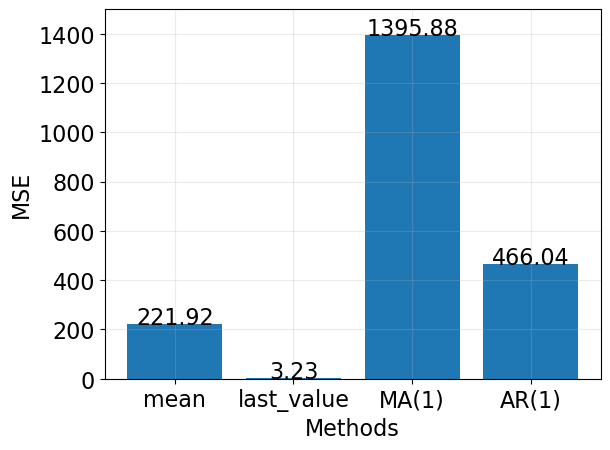

In [261]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "MA(1)", "AR(1)"]
y_array = [mse_mean_undiff, mse_last_undiff, mse_MA_undiff, mse_AR_undiff]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MSE")
ax.set_ylim([0, 1500])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)

RMSE

In [262]:
rmse_mean_undiff = np.sqrt(mse_mean_undiff)
rmse_last_undiff = np.sqrt(mse_last_undiff)
rmse_MA_undiff = np.sqrt(mse_MA_undiff)
rmse_AR_undiff = np.sqrt(mse_AR_undiff)

print(f"RMSE mean: {rmse_mean_undiff}")
print(f"RMSE last: {rmse_last_undiff}")
print(f"RMSE MA: {rmse_MA_undiff}")
print(f"RMSE AR: {rmse_AR_undiff}")

RMSE mean: 14.89689153980007
RMSE last: 1.798147194568157
RMSE MA: 37.361426975307964
RMSE AR: 21.587928007475735


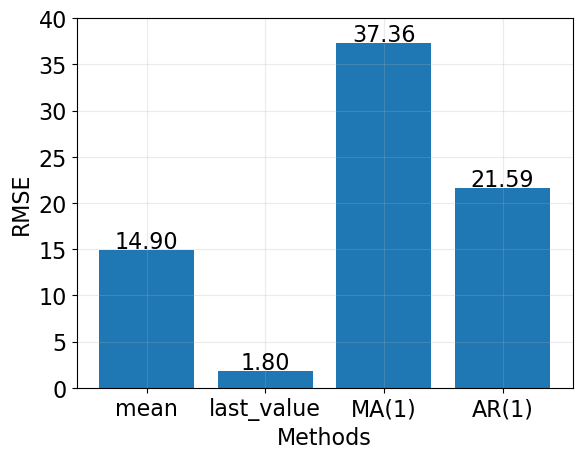

In [263]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "MA(1)", "AR(1)"]
y_array = [rmse_mean_undiff, rmse_last_undiff, rmse_MA_undiff, rmse_AR_undiff]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("RMSE")
ax.set_ylim([0, 40])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)

MAPE

In [264]:
mape_mean_undiff = mean_absolute_percentage_error(df_test_H["cumulative_sum"], df_test_H["pred_mean"]) * 100
mape_last_undiff = mean_absolute_percentage_error(df_test_H["cumulative_sum"], df_test_H["pred_last_value"]) * 100
mape_MA_undiff   = mean_absolute_percentage_error(df_test_H["cumulative_sum"], df_test_H["pred_MA"]) * 100
mape_AR_undiff   = mean_absolute_percentage_error(df_test_H["cumulative_sum"], df_test_H["pred_AR"]) * 100

print(f"MAPE mean: {mape_mean_undiff:.2f}%")
print(f"MAPE last: {mape_last_undiff:.2f}%")
print(f"MAPE MA: {mape_MA_undiff:.2f}%")
print(f"MAPE AR: {mape_AR_undiff:.2f}%")

MAPE mean: 3.04%
MAPE last: 0.25%
MAPE MA: 7.63%
MAPE AR: 4.32%


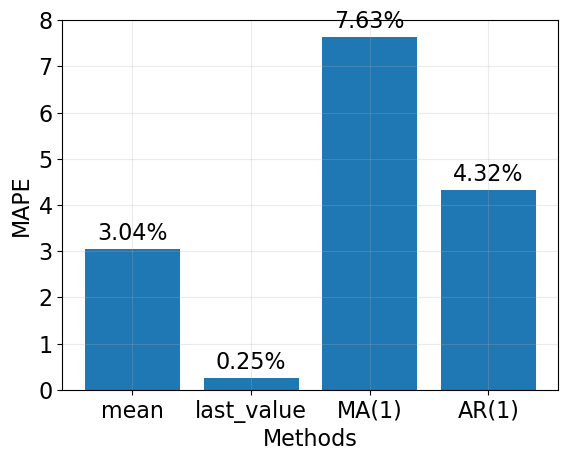

In [265]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "MA(1)", "AR(1)"]
y_array = [mape_mean_undiff, mape_last_undiff, mape_MA_undiff, mape_AR_undiff]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAPE")
ax.set_ylim([0, 8])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}%", ha="center")

plt.show(fig)

MASE

In [266]:
naive = np.abs(np.diff(df_test_H["cumulative_sum"])).mean()

mase_mean_undiff = mae_mean_undiff / naive
mase_last_undiff = mae_last_undiff / naive
mase_MA_undiff   = mae_MA_undiff / naive
mase_AR_undiff   = mae_AR_undiff / naive

print(f"MASE mean: {mase_mean_undiff}")
print(f"MASE last: {mase_last_undiff}")
print(f"MASE MA: {mase_MA_undiff}")
print(f"MASE AR: {mase_AR_undiff}")

MASE mean: 11.582739439270759
MASE last: 0.893939393939394
MASE MA: 29.07540822371296
MASE AR: 16.497266245928127


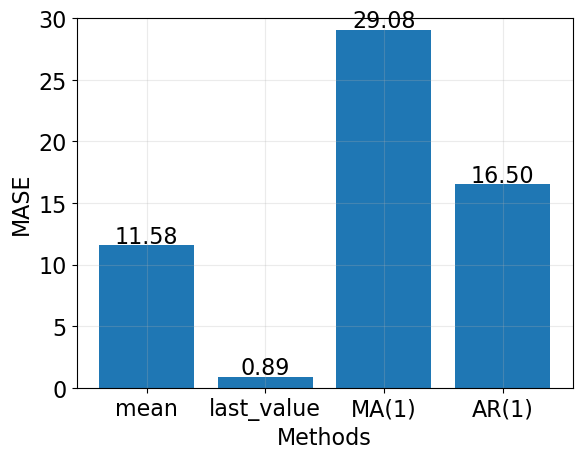

In [267]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "MA(1)", "AR(1)"]
y_array = [mase_mean_undiff, mase_last_undiff, mase_MA_undiff, mase_AR_undiff]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MASE")
ax.set_ylim([0, 30])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)

### Data Splitting ARIMA

In [304]:
split_idx = int(0.8 * len(df_H_count))
df_train_arima = df_H_count.iloc[:split_idx].copy()
df_test_arima = df_H_count.iloc[split_idx:].copy()

print(f"(len(df_train_arima), len(df_test_arima)): {len(df_train_arima), len(df_test_arima)}")

(len(df_train_arima), len(df_test_arima)): (240, 60)


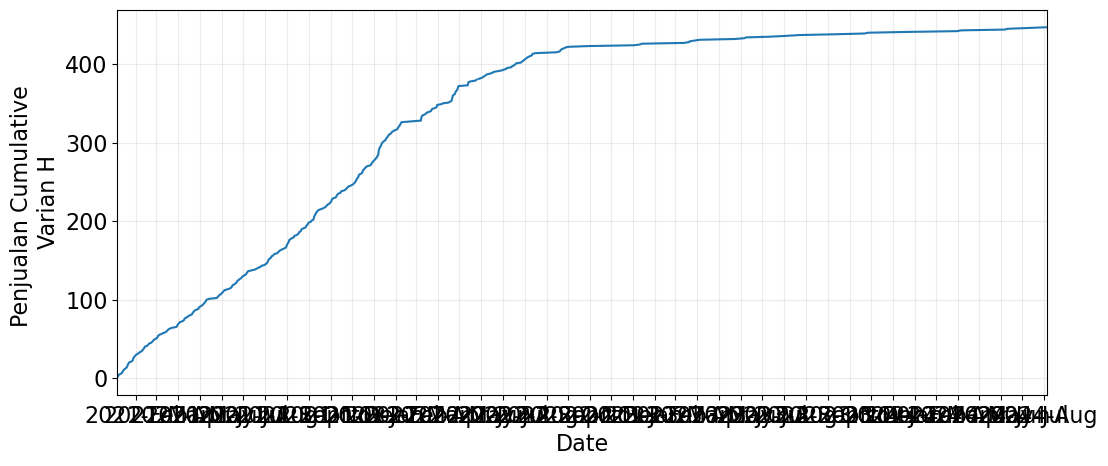

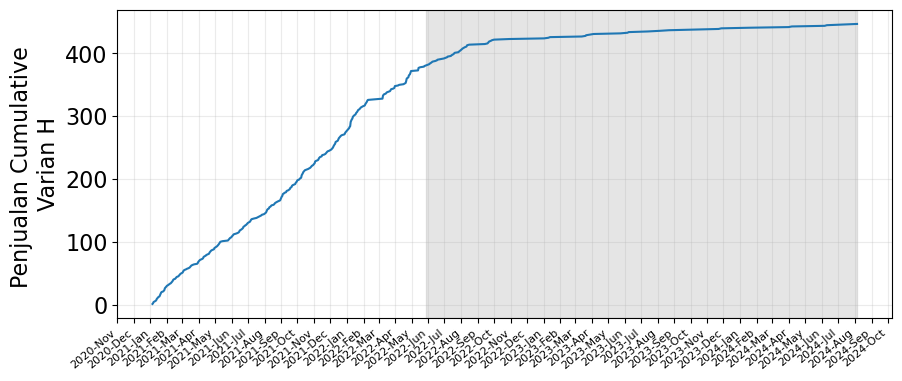

In [305]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(df_H_count['Tgl. Mohon'], df_H_count["cumulative_sum"])
ax.grid("on")
ax.set_ylabel("Penjualan Cumulative \nVarian H")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

# add forecast area
ax.axvspan(df_test_arima['Tgl. Mohon'].iloc[0], df_test_arima['Tgl. Mohon'].iloc[-1], 
                color="#808080", alpha=0.2)

for j, label in enumerate(ax.get_xticklabels()):
  label.set_rotation(40)
  label.set_size(8)
  label.set_horizontalalignment('right')

plt.show(fig)

### ARIMA (1,1,1)

In [313]:
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int, 
                    enforce_stationarity: bool=True, 
                    enforce_invertibility: bool=True) -> pd.DataFrame:

  result = []
  # warnings.filterwarnings("error")   # handling warnings as error
  warnings.resetwarnings()     # to reset warnings

  for order in notebook.tqdm(order_list):
    print(f"{(order[0], order[1])}")
    try:
      model = SARIMAX(endog, order=(order[0], d, order[1]), 
                      simple_differencing=False, 
                      enforce_invertibility=enforce_invertibility,
                      enforce_stationarity=enforce_stationarity).fit(disp=False)
    except:
      continue

    aic = model.aic
    result.append([order, aic])

  
  result_df = pd.DataFrame(result)
  # print(result_df.columns)
  result_df.columns = ["(p,q)", "AIC"]

  # Sort in ascending order, lower AIC is better
  result_df = result_df.sort_values(by="AIC", ascending=True).reset_index(drop=True)

  return result_df

In [314]:
p_space = range(0, 4, 1)
q_space = range(0, 4, 1)
d = 1

order_list = list(itertls.product(p_space, q_space))
order_list

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3)]

In [315]:
result_df = optimize_ARIMA(df_train_arima["cumulative_sum"], order_list, d,
                            enforce_invertibility=True,
                            enforce_stationarity=True)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

(0, 0)
(0, 1)
(0, 2)
(0, 3)
(1, 0)
(1, 1)
(1, 2)
(1, 3)


c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


(2, 0)
(2, 1)


c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


(2, 2)
(2, 3)


c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


(3, 0)
(3, 1)
(3, 2)
(3, 3)


c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,"(p,q)",AIC
0,"(1, 1)",642.765071
1,"(1, 2)",644.361801
2,"(2, 1)",644.390067
3,"(2, 2)",645.485943
4,"(3, 3)",646.057819
5,"(3, 1)",646.103113
6,"(1, 3)",646.115470
7,"(2, 3)",647.229635
8,"(3, 2)",647.245044
9,"(3, 0)",696.650961


In [316]:
best_p, best_q = (1, 1)
print(f"best (p,q): {(best_p, best_q)}")

best (p,q): (1, 1)


In [317]:
model_arima_best = SARIMAX(df_train_arima["cumulative_sum"], order=(best_p, d, best_q), 
                        simple_differencing=False)
model_arima_best_fit = model_arima_best.fit(disp=False)

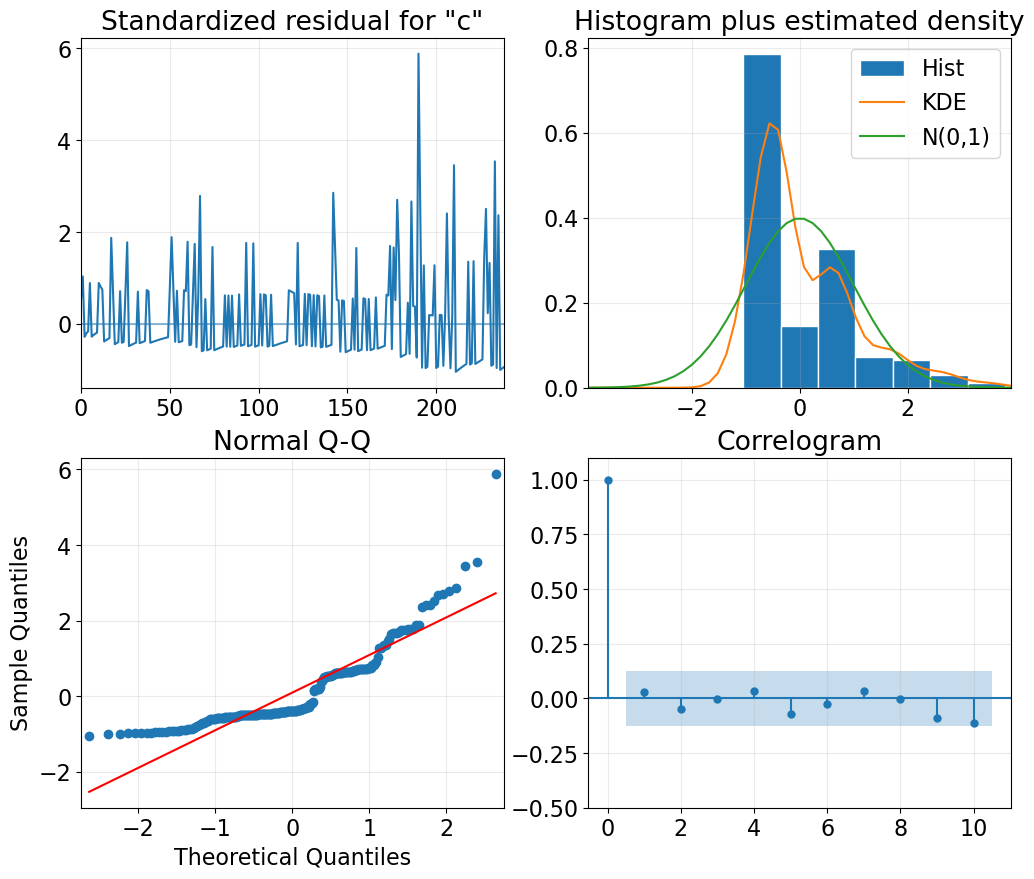

In [318]:
fig = model_arima_best_fit.plot_diagnostics(figsize=(12, 10))

# get all axes
axs = fig.get_axes()
for ax in axs:
  ax.grid("on")

# set y-lim for correlogram plot
axs[3].set_ylim([-0.5, 1.1])
plt.show(fig)

In [319]:
residuals = model_arima_best_fit.resid
ljung_box_test = acorr_ljungbox(residuals, np.arange(1, 11))
ljung_box_test

,lb_stat,lb_pvalue
1,0.342373,0.558463
2,0.804540,0.668800
3,0.812445,0.846488
4,1.050373,0.902064
5,2.274497,0.810005
6,2.393682,0.880171
7,2.600304,0.919357
8,2.606010,0.956604
9,4.566783,0.870322
10,7.682332,0.659835


In [323]:
df_test_pred_arima = df_test_arima.copy()

TRAIN_LEN = len(df_train_arima)
HORIZON = len(df_test_arima)

pred_mean = np.ones(HORIZON)*np.mean(df_train_arima["cumulative_sum"])
pred_naive_seasonal = df_train_arima["cumulative_sum"].iloc[-HORIZON:].values
pred_arima = model_arima_best_fit.get_prediction(
  TRAIN_LEN, TRAIN_LEN + HORIZON - 1).predicted_mean

df_test_pred_arima["pred_mean"] = pred_mean
df_test_pred_arima["pred_naive_seasonal"] = pred_naive_seasonal
df_test_pred_arima["pred_arima"] = pred_arima

df_test_pred_arima.head()

,Tgl. Mohon,count,cumulative_sum,pred_mean,pred_naive_seasonal,pred_arima
240,2022-05-28,1,381,177.466667,268,381.833510
241,2022-05-31,1,382,177.466667,269,383.666772
242,2022-06-03,1,383,177.466667,270,385.499786
243,2022-06-04,1,384,177.466667,271,387.332552
244,2022-06-06,1,385,177.466667,272,389.165071


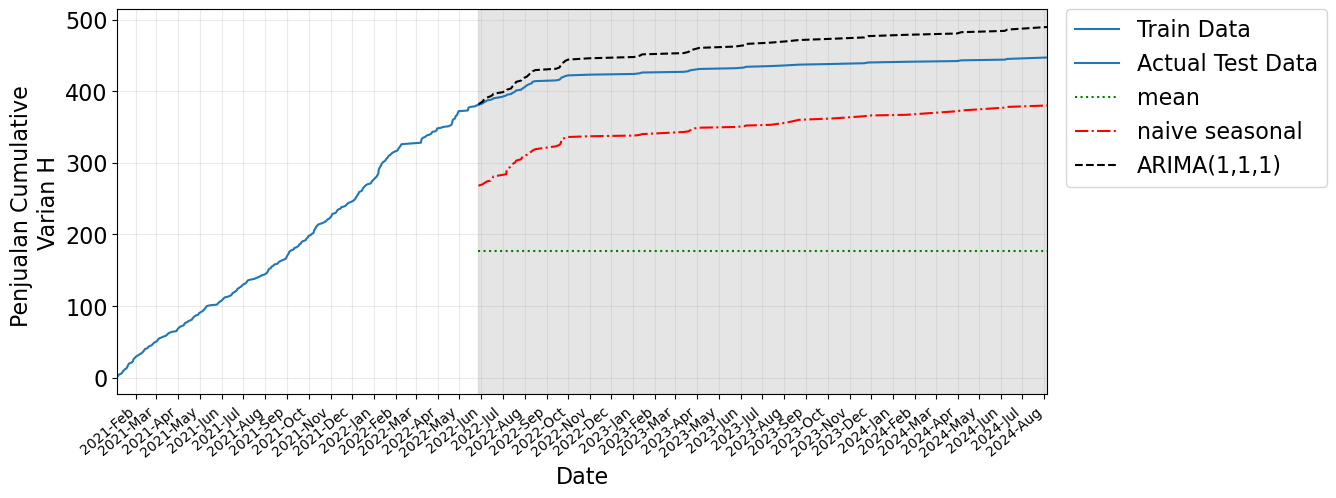

In [325]:
df_train_arima_extended = pd.concat([df_train_arima, df_test_arima.iloc[:1]], ignore_index=True)

start_idx = 0  # for better visualization
xlim = [df_train_arima_extended["Tgl. Mohon"].iloc[start_idx], df_test_arima["Tgl. Mohon"].iloc[-1]]

fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(df_train_arima_extended["Tgl. Mohon"], df_train_arima_extended["cumulative_sum"], label="Train Data")
ax.plot(df_test_arima["Tgl. Mohon"], df_test_arima["cumulative_sum"], color="tab:blue", label="Actual Test Data")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

# ax.set_ylim([-0.5, 17])
ax.set_xlim(xlim)
ax.grid("on")
ax.set_xlabel("Date")
ax.set_ylabel("Penjualan Cumulative \nVarian H")

# -- prediction
ax.plot(df_test_pred_arima["Tgl. Mohon"], df_test_pred_arima["pred_mean"], "g:", label="mean")
ax.plot(df_test_pred_arima["Tgl. Mohon"], df_test_pred_arima["pred_naive_seasonal"], "r-.", label="naive seasonal")
ax.plot(df_test_pred_arima["Tgl. Mohon"], df_test_pred_arima["pred_arima"], "k--", 
        label=f"ARIMA({best_p},{d},{best_q})")

# add forecast area
ax.axvspan(df_test_arima['Tgl. Mohon'].iloc[0], df_test_arima['Tgl. Mohon'].iloc[-1], 
                color="#808080", alpha=0.2)

for j, label in enumerate(ax.get_xticklabels()):
  label.set_rotation(40)
  label.set_size(10)
  label.set_horizontalalignment('right')

# -- add legend in the second row
ax.legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

plt.show(fig)

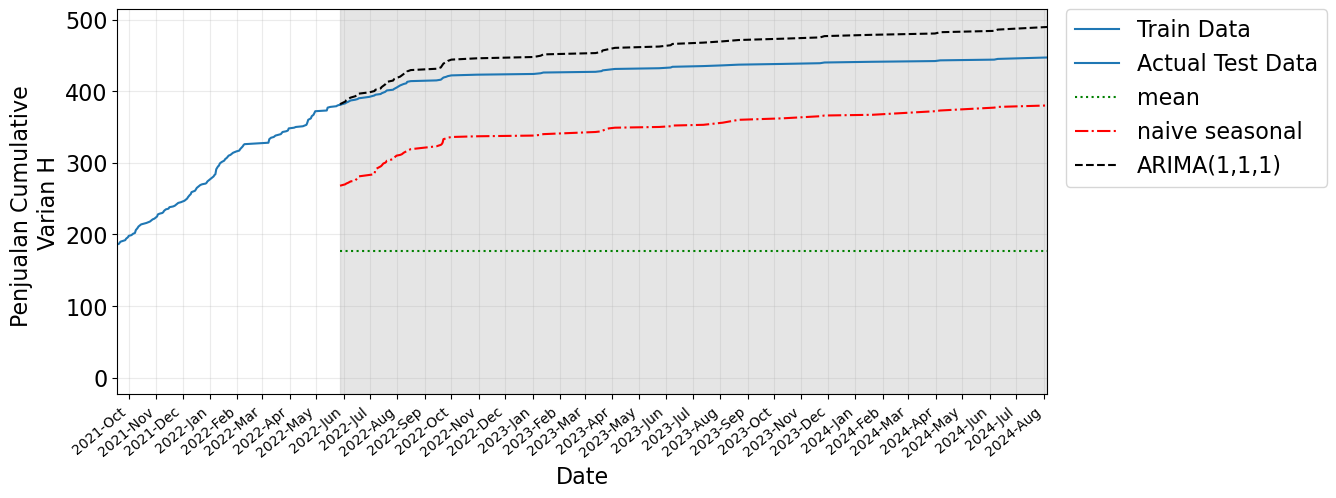

In [326]:
df_train_arima_extended = pd.concat([df_train_arima, df_test_arima.iloc[:1]], ignore_index=True)

start_idx = 130  # for better visualization
xlim = [df_train_arima_extended["Tgl. Mohon"].iloc[start_idx], df_test_arima["Tgl. Mohon"].iloc[-1]]

fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(df_train_arima_extended["Tgl. Mohon"], df_train_arima_extended["cumulative_sum"], label="Train Data")
ax.plot(df_test_arima["Tgl. Mohon"], df_test_arima["cumulative_sum"], color="tab:blue", label="Actual Test Data")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

# ax.set_ylim([-0.5, 17])
ax.set_xlim(xlim)
ax.grid("on")
ax.set_xlabel("Date")
ax.set_ylabel("Penjualan Cumulative \nVarian H")

# -- prediction
ax.plot(df_test_pred_arima["Tgl. Mohon"], df_test_pred_arima["pred_mean"], "g:", label="mean")
ax.plot(df_test_pred_arima["Tgl. Mohon"], df_test_pred_arima["pred_naive_seasonal"], "r-.", label="naive seasonal")
ax.plot(df_test_pred_arima["Tgl. Mohon"], df_test_pred_arima["pred_arima"], "k--", 
        label=f"ARIMA({best_p},{d},{best_q})")

# add forecast area
ax.axvspan(df_test_arima['Tgl. Mohon'].iloc[0], df_test_arima['Tgl. Mohon'].iloc[-1], 
                color="#808080", alpha=0.2)

for j, label in enumerate(ax.get_xticklabels()):
  label.set_rotation(40)
  label.set_size(10)
  label.set_horizontalalignment('right')

# -- add legend in the second row
ax.legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

plt.show(fig)

### Evaluasi ARIMA (1,1,1)

MAE

In [327]:
mae_mean           = mean_absolute_error(df_test_pred_arima["cumulative_sum"], df_test_pred_arima["pred_mean"])
mae_naive_seasonal = mean_absolute_error(df_test_pred_arima["cumulative_sum"], df_test_pred_arima["pred_naive_seasonal"])
mae_arima          = mean_absolute_error(df_test_pred_arima["cumulative_sum"], df_test_pred_arima["pred_arima"])

print(f"MAE mean: {mae_mean}")
print(f"MAE naive seasonal: {mae_naive_seasonal}")
print(f"MAE ARIMA: {mae_arima}")

MAE mean: 238.1833333333333
MAE naive seasonal: 90.88333333333334
MAE ARIMA: 20.123617740450282


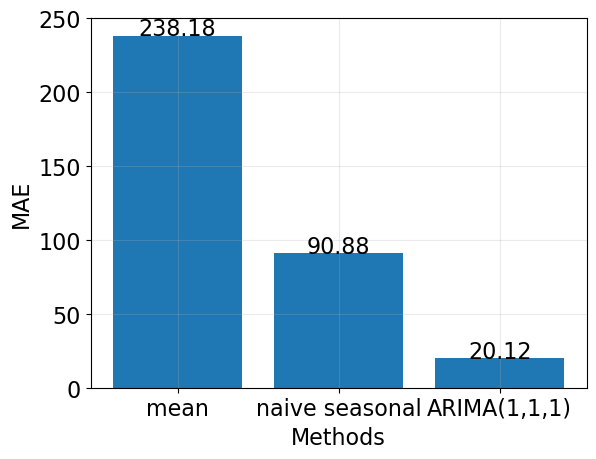

In [329]:
fig, ax = plt.subplots()

x_array = ["mean", "naive seasonal", "ARIMA(1,1,1)"]
y_array = [mae_mean, mae_naive_seasonal, mae_arima]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAE")
ax.set_ylim([0, 250])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.1, s=f"{val:.2f}", ha="center")

plt.show(fig)

MSE

In [330]:
mse_mean           = mean_squared_error(df_test_pred_arima["cumulative_sum"], df_test_pred_arima["pred_mean"])
mse_naive_seasonal = mean_squared_error(df_test_pred_arima["cumulative_sum"], df_test_pred_arima["pred_naive_seasonal"])
mse_arima          = mean_squared_error(df_test_pred_arima["cumulative_sum"], df_test_pred_arima["pred_arima"])

print(f"MSE mean: {mse_mean}")
print(f"MSE naive seasonal: {mse_naive_seasonal}")
print(f"MSE ARIMA: {mse_arima}")

MSE mean: 57113.36111111111
MSE naive seasonal: 8443.583333333334
MSE ARIMA: 553.3146498211776


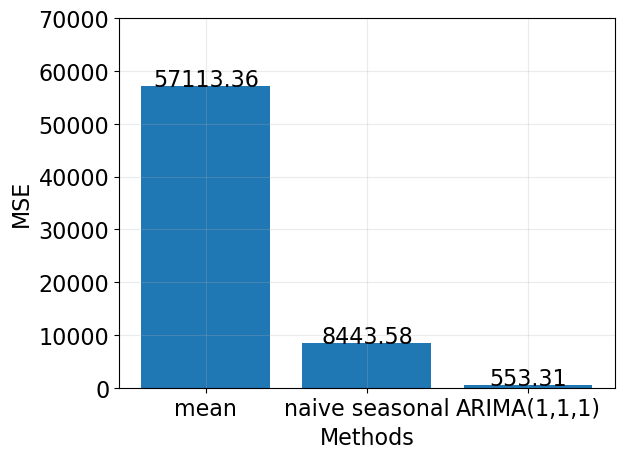

In [331]:
fig, ax = plt.subplots()

x_array = ["mean", "naive seasonal", "ARIMA(1,1,1)"]
y_array = [mse_mean, mse_naive_seasonal, mse_arima]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MSE")
ax.set_ylim([0, 70000])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.1, s=f"{val:.2f}", ha="center")

plt.show(fig)

RMSE

In [332]:
rmse_mean           = np.sqrt(mse_mean)
rmse_naive_seasonal = np.sqrt(mse_naive_seasonal)
rmse_arima          = np.sqrt(mse_arima)

print(f"RMSE mean: {rmse_mean}")
print(f"RMSE naive seasonal: {rmse_naive_seasonal}")
print(f"RMSE ARIMA: {rmse_arima}")

RMSE mean: 238.9840185265766
RMSE naive seasonal: 91.88897286036739
RMSE ARIMA: 23.52264121694623


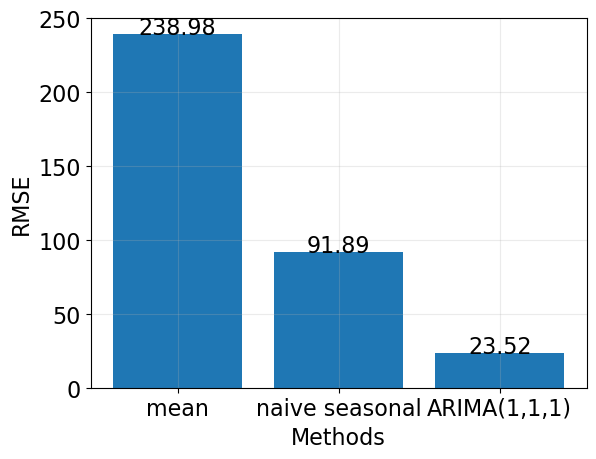

In [333]:
fig, ax = plt.subplots()

x_array = ["mean", "naive seasonal", "ARIMA(1,1,1)"]
y_array = [rmse_mean, rmse_naive_seasonal, rmse_arima]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("RMSE")
ax.set_ylim([0, 250])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.1, s=f"{val:.2f}", ha="center")

plt.show(fig)

MAPE

In [334]:
mape_mean           = np.mean(np.abs((df_test_pred_arima["cumulative_sum"] - df_test_pred_arima["pred_mean"]) / df_test_pred_arima["cumulative_sum"])) * 100
mape_naive_seasonal = np.mean(np.abs((df_test_pred_arima["cumulative_sum"] - df_test_pred_arima["pred_naive_seasonal"]) / df_test_pred_arima["cumulative_sum"])) * 100
mape_arima          = np.mean(np.abs((df_test_pred_arima["cumulative_sum"] - df_test_pred_arima["pred_arima"]) / df_test_pred_arima["cumulative_sum"])) * 100

print(f"MAPE mean: {mape_mean:.2f}%")
print(f"MAPE naive seasonal: {mape_naive_seasonal:.2f}%")
print(f"MAPE ARIMA: {mape_arima:.2f}%")

MAPE mean: 57.21%
MAPE naive seasonal: 22.07%
MAPE ARIMA: 4.72%


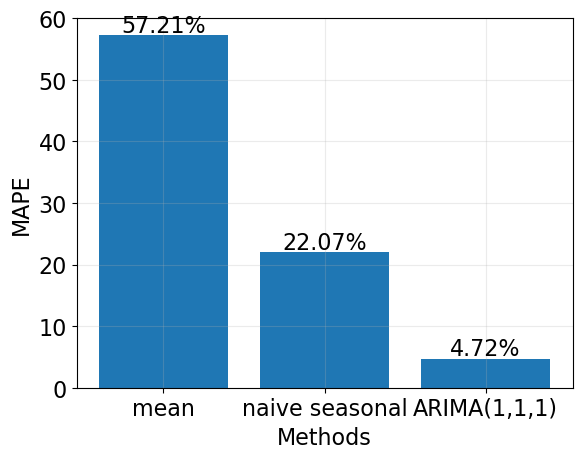

In [336]:
fig, ax = plt.subplots()

x_array = ["mean", "naive seasonal", "ARIMA(1,1,1)"]
y_array = [mape_mean, mape_naive_seasonal, mape_arima]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAPE")
ax.set_ylim([0, 60])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.5, s=f"{val:.2f}%", ha="center")

plt.show(fig)

In [337]:
naive = np.abs(np.diff(df_test_pred_arima["cumulative_sum"])).mean()

mase_mean           = mae_mean_undiff / naive
mase_naive_seasonal = mae_naive_seasonal / naive
mase_arima          = mae_arima / naive

print(f"MASE mean: {mase_mean}")
print(f"MASE naive seasonal: {mase_naive_seasonal}")
print(f"MASE ARIMA: {mase_arima}")

MASE mean: 11.582739439270759
MASE naive seasonal: 81.24419191919193
MASE ARIMA: 17.98929464676616


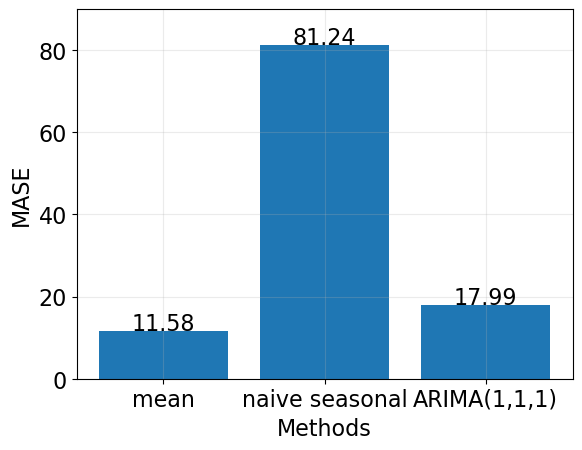

In [339]:
fig, ax = plt.subplots()

x_array = ["mean", "naive seasonal", "ARIMA(1,1,1)"]
y_array = [mase_mean, mase_naive_seasonal, mase_arima]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MASE")
ax.set_ylim([0, 90])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)